In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [10]:
class MeanShift:
    def __init__(self, bandwidth, tolerance, sigma):
        self.bandwidth = bandwidth
        self.tolerance = tolerance
        self.sigma = sigma

    def fit(self, image):
        img = np.array(image, copy=True, dtype=float)
        features = img.reshape(-1, img.shape[2])
        num_points = len(features)
        visited = np.full(num_points, False, dtype=bool)
        meanshift_clusters = []
        while np.sum(visited) < num_points:
            initial_idx = np.random.choice(np.arange(num_points)[~visited])
            initial_mean = features[initial_idx]
            while True:
                distances = np.linalg.norm(initial_mean - features, axis=1)
                gauss_weight = self.gaussian_kernel(distances)
                indx_within_bandwidth = np.where(distances <= self.bandwidth / 2)[0]
                within_bandwidth_bool = np.full(num_points, False, dtype=bool)
                within_bandwidth_bool[indx_within_bandwidth] = True
                points_within_bandwidth = features[indx_within_bandwidth]
                new_mean = np.average(points_within_bandwidth, axis=0, weights=gauss_weight[indx_within_bandwidth])
                if np.linalg.norm(new_mean - initial_mean) < self.tolerance:
                    merged = False
                    for cluster in meanshift_clusters:
                        if np.linalg.norm(cluster['center'] - new_mean) < 0.5 * self.bandwidth:
                            cluster['points'] = cluster['points'] + within_bandwidth_bool
                            cluster['center'] = 0.5 * (cluster['center'] + new_mean)
                            merged = True
                            break
                    if not merged:
                        meanshift_clusters.append({'points': within_bandwidth_bool, 'center': new_mean})
                    visited[indx_within_bandwidth] = True
                    break
                initial_mean = new_mean
        return meanshift_clusters
    
    def gaussian_kernel(self, distances):
        return np.exp(-0.5 * (distances / self.sigma) ** 2)


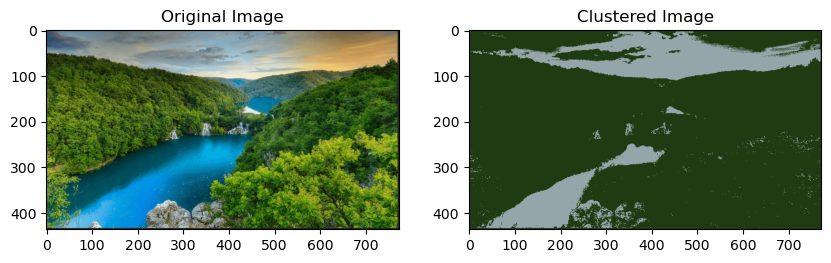

In [22]:
image = cv2.imread("C:/Study/CV/CV_Tasks/Filtering_and_Edge_Detection_Studio/test-images/seg-image.png")  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
bandwidth = 200
tolerance = 10
sigma = 20
mean_shift = MeanShift(bandwidth, tolerance, sigma)
meanshift_clusters = mean_shift.fit(image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
clustered_image = np.zeros_like(image)
for cluster in meanshift_clusters:
    points = cluster['points'].reshape(image.shape[:2])
    clustered_image[points, :] = cluster["center"] 
plt.imshow(clustered_image)
plt.title('Clustered Image')

plt.show()
